In [1]:
import pandas as pd
import sklearn
import random, os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from fairness_evals import positive_rates, true_postive_rates, true_negative_rate, false_postive_rates
from Dataverwerking.reweighing import getweights

# Data

In [2]:
data_old = pd.read_csv(os.path.join('Processed_data', 'adult.csv'))

In [3]:
weights = getweights(os.path.join('Processed_data', 'adult.csv'))
data_old['weights'] = weights
data_old = data_old.drop(columns=['race'])
data_old

,age,workclass,education,marital.status,sex,hours.per.week,income,weights
0,82,Private,HS-grad,Widowed,Female,18,0,0.561784
1,54,Private,7th-8th,Divorced,Female,40,0,0.733710
2,41,Private,Some-college,Separated,Female,40,0,0.621668
3,34,Private,HS-grad,Divorced,Female,45,0,0.733710
4,38,Private,10th,Separated,Male,40,0,0.696527
...,...,...,...,...,...,...,...,...
30157,22,Private,Some-college,Never-married,Male,40,0,1.041887
30158,27,Private,Assoc,Married,Female,38,0,4.033258
30159,40,Private,HS-grad,Married,Male,40,1,0.660456
30160,58,Private,HS-grad,Widowed,Female,40,0,0.561784


In [4]:
data_2018 = pd.read_csv(os.path.join('Processed_data', 'data_2018.csv'))
data_2018 = data_2018.drop(columns=['race'])

In [5]:
DATA = data_old #data to train on 
# DATA.drop(columns=['occupation'])
FEAT_OF_INT = ['education', 'marital.status', 'sex', 'income'] #The features we are interested in
DATA.head()

,age,workclass,education,marital.status,sex,hours.per.week,income,weights
0,82,Private,HS-grad,Widowed,Female,18,0,0.561784
1,54,Private,7th-8th,Divorced,Female,40,0,0.733710
2,41,Private,Some-college,Separated,Female,40,0,0.621668
3,34,Private,HS-grad,Divorced,Female,45,0,0.733710
4,38,Private,10th,Separated,Male,40,0,0.696527


## Encoder for categorical values

In [6]:
from sklearn.preprocessing import OneHotEncoder
cat_feats = list(DATA.select_dtypes("object").keys())  #names of all categorical features
print(f"{len(cat_feats)} categorical features found: {cat_feats}")

cat_feat_encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform="pandas")
cat_feat_encoder = cat_feat_encoder.fit(DATA[cat_feats])

4 categorical features found: ['workclass', 'education', 'marital.status', 'sex']


## Split train, dev and test

In [7]:
train, rest = train_test_split(DATA, test_size=0.3, random_state= 64819)
dev, test_old = train_test_split(rest, test_size=2/3, random_state= 8910)
test_2018 = data_2018
print(f"Train size: {len(train)}, dev size: {len(dev)}, test old size: {len(test_old)}, test 2018 size: {len(test_2018)}")

Train size: 21113, dev size: 3016, test old size: 6033, test 2018 size: 1667195


In [8]:
#sample test old to reweigh 
test_old_weighted = test_old.sample(n=len(test_old), replace=True, weights=test_old['weights'], random_state=5819)

In [9]:
x_train = train.drop(columns=['income', 'weights'])
y_train = train['income']
weights_train = train['weights']

x_dev  = dev.drop(columns=['income', 'weights'])
y_dev  = dev['income']

x_test_old  = test_old.drop(columns=['income', 'weights'])
y_test_old  = test_old['income']

x_test_old_weighted  = test_old_weighted.drop(columns=['income', 'weights'])
y_test_old_weighted  = test_old_weighted['income']

x_test_2018  = test_2018.drop(columns=['income'])
y_test_2018  = test_2018['income']

In [10]:
from Dataverwerking.data_transform import cat_to_one_hot
x_train_encoded = cat_to_one_hot(x_train, cat_feats, cat_feat_encoder)
x_dev_encoded = cat_to_one_hot(x_dev, cat_feats, cat_feat_encoder)
x_test_old_weighted_encoded = cat_to_one_hot(x_test_old_weighted, cat_feats, cat_feat_encoder)
x_test_old_encoded = cat_to_one_hot(x_test_old, cat_feats, cat_feat_encoder)
x_test_2018_encoded = cat_to_one_hot(x_test_2018, cat_feats, cat_feat_encoder)

# Logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver = 'lbfgs', max_iter=250, class_weight={0: 0.32, 1: 0.68}).fit(x_train_encoded, y_train, sample_weight= weights_train)

/Users/jip/Documents/Uni_master/Human-Centered ML/HCML_project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
from collections import defaultdict
import numpy as np 
feat_weights = [np.abs(x) for x in logreg.coef_[0]]
feat_names = list(logreg.feature_names_in_)
FI = defaultdict(int)
for c, name in zip(feat_weights, feat_names):
    split_name = name.split('_')
    orig_name = split_name[0]
    # print(orig_name)
    if len(split_name) > 1:
        value_name = split_name[1]
        # print(value_name)
        importance = train[orig_name].value_counts()[value_name]/ len (train[orig_name]) * c
    else: importance = c
    FI[orig_name] += importance
print(FI)

defaultdict(<class 'int'>, {'age': 0.02857411806994773, 'hours.per.week': 0.025578616970302732, 'workclass': 0.5482626736222813, 'education': 0.8148227868846498, 'marital.status': 1.2167352141296803, 'sex': 0.033636915226908884})


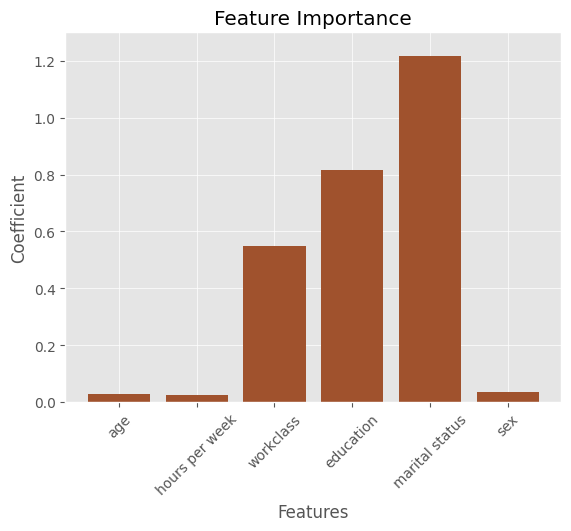

In [30]:
import matplotlib.pyplot as plt 
from matplotlib import style 
feat_weights = [np.abs(x) for x in logreg.coef_[0]]
feat_names = list(logreg.feature_names_in_)
names = [name.replace('.', ' ') for name, _ in FI.items()]
values = [value for _, value in FI.items()]
plt.bar(names, values, width=0.8, color = 'sienna')
plt.style.use('ggplot')
plt.xticks(rotation = 45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.ylim(0, 1.3)
plt.title('Feature Importance')
plt.savefig(os.path.join('plots', 'feature_importance_weighted'), bbox_inches='tight')
plt.show()


## Dev evaluation

In [14]:
y_pred_dev= list(logreg.predict(x_dev_encoded))

logreg_results_dev = dev.copy() #get all the data of the dev set

logreg_results_dev = logreg_results_dev.filter(items=FEAT_OF_INT) #keep only relevant info
logreg_results_dev['y_pred'] = y_pred_dev
logreg_results_dev

,education,marital.status,sex,income,y_pred
25299,Some-college,Separated,Female,0,0
938,HS-grad,Married,Male,1,1
9113,HS-grad,Never-married,Male,0,0
19694,10th,Married,Male,1,1
22532,Bachelors,Divorced,Female,0,0
...,...,...,...,...,...
12403,Bachelors,Never-married,Female,0,0
15435,12th,Widowed,Female,0,0
26831,HS-grad,Married,Male,1,0
11994,Some-college,Never-married,Male,0,0


In [15]:
logreg_acc_dev = accuracy_score(y_dev, y_pred_dev)
logreg_rec_dev = recall_score(y_dev, y_pred_dev)
logreg_pre_dev = precision_score(y_dev, y_pred_dev)
logreg_f1_dev = f1_score(y_dev, y_pred_dev)
logreg_eval_dev = pd.DataFrame({'accuracy': [logreg_acc_dev], 'recall': [logreg_rec_dev], 'precision': [logreg_pre_dev], 'f1': [logreg_f1_dev]}, index=['dev'])
# logreg_eval_dev.to_csv(os.path.join('Results', f'dev_{DATA_NAME}_eval.csv'),sep='\t')
logreg_eval_dev

,accuracy,recall,precision,f1
dev,0.783488,0.767016,0.552309,0.642192


In [16]:
logreg_fair_eval_dev = pd.DataFrame()
logreg_fair_eval_dev['positive rates'] = positive_rates(logreg_results_dev, 'sex')
logreg_fair_eval_dev['true positive rates'] = true_postive_rates(logreg_results_dev, 'sex')
logreg_fair_eval_dev['true negative rates'] = true_negative_rate(logreg_results_dev, 'sex')
logreg_fair_eval_dev['false positive rates'] = false_postive_rates(logreg_results_dev, 'sex')
# logreg_fair_eval_dev.to_csv(os.path.join('Results', f'dev_{DATA_NAME}_fair_eval.csv'),sep='\t')
logreg_fair_eval_dev


,positive rates,true positive rates,true negative rates,false positive rates
Female,0.121704,0.612069,0.943678,0.056322
Male,0.463547,0.794753,0.691751,0.308249


## Test 2018 evaluation

In [17]:
y_pred_test_2018 = list(logreg.predict(x_test_2018_encoded))

logreg_results_test_2018 = test_2018.copy() #get all the data of the dev set

logreg_results_test_2018 = logreg_results_test_2018.filter(items=FEAT_OF_INT) #keep only relevant info
logreg_results_test_2018['y_pred'] = y_pred_test_2018
logreg_results_test_2018

,education,marital.status,sex,income,y_pred
0,Some-college,Never-married,Female,0,0
1,HS-grad,Never-married,Male,0,0
2,HS-grad,Never-married,Male,0,0
3,Some-college,Never-married,Female,0,0
4,Some-college,Never-married,Male,0,0
...,...,...,...,...,...
1667190,HS-grad,Never-married,Male,0,0
1667191,11th,Never-married,Male,0,0
1667192,Some-college,Divorced,Female,0,0
1667193,HS-grad,Married,Male,0,1


In [18]:
logreg_acc_test_2018 = accuracy_score(y_test_2018, y_pred_test_2018)
logreg_rec_test_2018 = recall_score(y_test_2018, y_pred_test_2018)
logreg_pre_test_2018 = precision_score(y_test_2018, y_pred_test_2018)
logreg_f1_test_2018 = f1_score(y_test_2018, y_pred_test_2018)
logreg_eval_test_2018 = pd.DataFrame({'accuracy': [logreg_acc_test_2018], 'recall': [logreg_rec_test_2018], 'precision': [logreg_pre_test_2018], 'f1': [logreg_f1_test_2018]}, index=['test'])
logreg_eval_test_2018.to_csv(os.path.join('Results', 'weighted', 'test_2018_eval.csv'),sep='\t')
logreg_eval_test_2018

,accuracy,recall,precision,f1
test,0.684961,0.707405,0.556789,0.623125


In [19]:
logreg_fair_eval_test_2018 = pd.DataFrame()
logreg_fair_eval_test_2018['positive rates'] = positive_rates(logreg_results_test_2018, 'sex')
logreg_fair_eval_test_2018['true positive rates'] = true_postive_rates(logreg_results_test_2018, 'sex')
logreg_fair_eval_test_2018['true negative rates'] = true_negative_rate(logreg_results_test_2018, 'sex')
logreg_fair_eval_test_2018['false positive rates'] = false_postive_rates(logreg_results_test_2018, 'sex')

logreg_fair_eval_test_2018['TP ratio'] = logreg_fair_eval_test_2018['true positive rates']['Male']/logreg_fair_eval_test_2018['true positive rates']['Female']
logreg_fair_eval_test_2018['TP diff'] = logreg_fair_eval_test_2018['true positive rates']['Male']-logreg_fair_eval_test_2018['true positive rates']['Female']

logreg_fair_eval_test_2018['FP ratio'] = logreg_fair_eval_test_2018['false positive rates']['Male']/logreg_fair_eval_test_2018['false positive rates']['Female']
logreg_fair_eval_test_2018['FP diff'] = logreg_fair_eval_test_2018['false positive rates']['Male']-logreg_fair_eval_test_2018['false positive rates']['Female']

logreg_fair_eval_test_2018.to_csv(os.path.join('Results', 'weighted', 'test_2018_fair_eval.csv'),sep='\t')
logreg_fair_eval_test_2018


,positive rates,true positive rates,true negative rates,false positive rates,TP ratio,TP diff,FP ratio,FP diff
Female,0.442193,0.665641,0.648765,0.351235,1.100647,0.066994,0.857201,-0.050156
Male,0.491288,0.732636,0.698921,0.301079,1.100647,0.066994,0.857201,-0.050156


## Test old weighted evaluation

In [20]:
y_pred_test_old_weighted = list(logreg.predict(x_test_old_weighted_encoded))

logreg_results_test_old_weighted = test_old_weighted.copy() #get all the data of the dev set

logreg_results_test_old_weighted = logreg_results_test_old_weighted.filter(items=FEAT_OF_INT) #keep only relevant info
logreg_results_test_old_weighted['y_pred'] = y_pred_test_old_weighted
logreg_results_test_old_weighted

,education,marital.status,sex,income,y_pred
23624,Bachelors,Never-married,Female,0,0
7962,Some-college,Never-married,Male,0,0
11575,Bachelors,Married,Male,0,1
6629,10th,Never-married,Female,0,0
1024,Prof-school,Divorced,Female,0,1
...,...,...,...,...,...
9494,Assoc,Married,Female,0,1
17362,Assoc,Married,Female,0,1
4264,Some-college,Never-married,Female,0,0
22756,Assoc,Never-married,Male,0,0


In [21]:
logreg_acc_test_old_weighted = accuracy_score(y_test_old_weighted, y_pred_test_old_weighted)
logreg_rec_test_old_weighted = recall_score(y_test_old_weighted, y_pred_test_old_weighted)
logreg_pre_test_old_weighted = precision_score(y_test_old_weighted, y_pred_test_old_weighted)
logreg_f1_test_old_weighted = f1_score(y_test_old_weighted, y_pred_test_old_weighted)
logreg_eval_test_old_weighted = pd.DataFrame({'accuracy': [logreg_acc_test_old_weighted], 'recall': [logreg_rec_test_old_weighted], 'precision': [logreg_pre_test_old_weighted], 'f1': [logreg_f1_test_old_weighted]}, index=['test'])
logreg_eval_test_old_weighted.to_csv(os.path.join('Results', 'weighted', 'test_old_weighted_eval.csv'),sep='\t')
logreg_eval_test_old_weighted

,accuracy,recall,precision,f1
test,0.788828,0.744236,0.529201,0.618563


In [22]:
logreg_fair_eval_test_old_weighted = pd.DataFrame()
logreg_fair_eval_test_old_weighted['positive rates'] = positive_rates(logreg_results_test_old_weighted, 'sex')
logreg_fair_eval_test_old_weighted['true positive rates'] = true_postive_rates(logreg_results_test_old_weighted, 'sex')
logreg_fair_eval_test_old_weighted['true negative rates'] = true_negative_rate(logreg_results_test_old_weighted, 'sex')
logreg_fair_eval_test_old_weighted['false positive rates'] = false_postive_rates(logreg_results_test_old_weighted, 'sex')

logreg_fair_eval_test_old_weighted['TP ratio'] = logreg_fair_eval_test_old_weighted['true positive rates']['Male']/logreg_fair_eval_test_old_weighted['true positive rates']['Female']
logreg_fair_eval_test_old_weighted['TP diff'] = logreg_fair_eval_test_old_weighted['true positive rates']['Male']-logreg_fair_eval_test_old_weighted['true positive rates']['Female']

logreg_fair_eval_test_old_weighted['FP ratio'] = logreg_fair_eval_test_old_weighted['false positive rates']['Male']/logreg_fair_eval_test_old_weighted['false positive rates']['Female']
logreg_fair_eval_test_old_weighted['FP diff'] = logreg_fair_eval_test_old_weighted['false positive rates']['Male']-logreg_fair_eval_test_old_weighted['false positive rates']['Female']

logreg_fair_eval_test_old_weighted.to_csv(os.path.join('Results', 'weighted', 'test_old_weighted_fair_eval.csv'),sep='\t')
logreg_fair_eval_test_old_weighted


,positive rates,true positive rates,true negative rates,false positive rates,TP ratio,TP diff,FP ratio,FP diff
Female,0.254456,0.662651,0.849561,0.150439,1.211761,0.140323,1.618945,0.093113
Male,0.385876,0.802974,0.756448,0.243552,1.211761,0.140323,1.618945,0.093113


## Test old evaluation

In [23]:
y_pred_test_old = list(logreg.predict(x_test_old_encoded))

logreg_results_test_old = test_old.copy() #get all the data of the dev set

logreg_results_test_old = logreg_results_test_old.filter(items=FEAT_OF_INT) #keep only relevant info
logreg_results_test_old['y_pred'] = y_pred_test_old
logreg_results_test_old

,education,marital.status,sex,income,y_pred
16340,Assoc,Married,Male,0,1
3137,Bachelors,Married,Male,1,1
20933,HS-grad,Married,Male,0,0
798,Masters,Married,Male,1,1
23387,HS-grad,Married,Male,0,1
...,...,...,...,...,...
11102,Doctorate,Never-married,Male,1,0
21409,12th,Never-married,Female,0,0
24728,Some-college,Never-married,Male,0,0
9872,Some-college,Married,Male,1,1


In [24]:
logreg_acc_test_old = accuracy_score(y_test_old, y_pred_test_old)
logreg_rec_test_old = recall_score(y_test_old, y_pred_test_old)
logreg_pre_test_old = precision_score(y_test_old, y_pred_test_old)
logreg_f1_test_old = f1_score(y_test_old, y_pred_test_old)
logreg_eval_test_old = pd.DataFrame({'accuracy': [logreg_acc_test_old], 'recall': [logreg_rec_test_old], 'precision': [logreg_pre_test_old], 'f1': [logreg_f1_test_old]}, index=['test'])
logreg_eval_test_old.to_csv(os.path.join('Results', 'weighted', 'test_old_eval.csv'),sep='\t')
logreg_eval_test_old

,accuracy,recall,precision,f1
test,0.790817,0.773138,0.542745,0.637773


In [25]:
logreg_fair_eval_test_old = pd.DataFrame()
logreg_fair_eval_test_old['positive rates'] = positive_rates(logreg_results_test_old, 'sex')
logreg_fair_eval_test_old['true positive rates'] = true_postive_rates(logreg_results_test_old, 'sex')
logreg_fair_eval_test_old['true negative rates'] = true_negative_rate(logreg_results_test_old, 'sex')
logreg_fair_eval_test_old['false positive rates'] = false_postive_rates(logreg_results_test_old, 'sex')

logreg_fair_eval_test_old['TP ratio'] = logreg_fair_eval_test_old['true positive rates']['Male']/logreg_fair_eval_test_old['true positive rates']['Female']
logreg_fair_eval_test_old['TP diff'] = logreg_fair_eval_test_old['true positive rates']['Male']-logreg_fair_eval_test_old['true positive rates']['Female']

logreg_fair_eval_test_old['FP ratio'] = logreg_fair_eval_test_old['false positive rates']['Male']/logreg_fair_eval_test_old['false positive rates']['Female']
logreg_fair_eval_test_old['FP diff'] = logreg_fair_eval_test_old['false positive rates']['Male']-logreg_fair_eval_test_old['false positive rates']['Female']

logreg_fair_eval_test_old.to_csv(os.path.join('Results', 'weighted', 'test_old_fair_eval.csv'),sep='\t')
logreg_fair_eval_test_old


,positive rates,true positive rates,true negative rates,false positive rates,TP ratio,TP diff,FP ratio,FP diff
Male,0.444336,0.817661,0.714584,0.285416,1.576392,0.29897,4.239411,0.218092
Female,0.117192,0.518692,0.932676,0.067324,1.576392,0.29897,4.239411,0.218092
